In [4]:
%matplotlib notebook

In [19]:
cd ~/bmi_dynamics_code/

/Users/preeyakhanna/bmi_dynamics_code


In [20]:
from online_analysis import util_fcns

In [5]:
### get out data
# act, com, cond, pot = return_data(model = 'n_do')
# cc_dist_do, shuff_cc_dist_do = get_cond_com_pls_matched_inds(com, cond, act, pot, nshuff=100)
# plot(cc_dist_do, shuff_cc_dist_do, 'null_do')

# # ### get out data
# act, com, cond, pot = return_data(model = 'n_o')
# cc_dist_o, shuff_cc_dist_o = get_cond_com_pls_matched_inds(com, cond, act, pot)
# plot(cc_dist_o, shuff_cc_dist_o, 'null_o')
 
# f, ax = plt.subplots(figsize = (3, 5))
# nm = []
# for k in cc_dist_do.keys(): 
#     norm = cc_dist_do[k] / np.mean(shuff_cc_dist_do[k])
#     ax.plot(.1*np.random.rand(), norm, 'b.')
#     nm.append(norm)
# ax.bar(0, np.median(nm), alpha=0.5)

# nm = []
# for k in cc_dist_o.keys(): 
#     norm = cc_dist_o[k] / np.mean(shuff_cc_dist_o[k])
#     ax.plot(1 + .1*np.random.rand(), norm, 'k.')
#     nm.append(norm)
# ax.bar(1, np.median(nm), alpha=0.5)
# ax.set_ylim([.1, 5.])
# ax.set_xticks([0, 1])
# ax.set_xticklabels(['n_do', 'n_o'])
# ax.set_ylabel('dist / mn(shuff dist)')
# f.tight_layout()

In [6]:
def return_null_lqr_data(model = 'n_do', simulation='df_lqr_n'): 
    '''
    options to get out data from vivek's DF
    inputs: 
        model: 'n_do' or 'n_o'
        simulation: 'df_lqr_n' or 'df_lqr_nl'
    '''
    ## Fixed point simulations -- null 
    df = pickle.load(open('/Users/preeyakhanna/Dropbox/Carmena_Lab/Documentation/BMI_co_obs_paper/data/lqr_init_fp_decoder_null_noisy.pkl'))
    N = df['num_neurons']
    cols = ['n_%d'%n for n in range(N)]
    
    ### activity 
    ### "'df_lqr_n', it's the data frame storing the noisy lqr simulation"
    ### @Preeya fyi, the variable 'df_lqr_nl' in the data I sent you is the noiseless simulation, and the dataframe has the same structure as 'df_lqr_n'
    act = np.array(df[simulation].loc[:, cols])
    
    ### Get command ID \n",
    ### u_v_mag_bin, u_v_angle_bin are the bins for magnitude and angle of command
    mag = np.array(df[simulation].loc[:, 'u_v_mag_bin'])
    ang = np.array(df[simulation].loc[:, 'u_v_angle_bin'])
    command = mag*8 + ang; # calculate command (if mag == 4, command will be 32-39)

    ## Get condition 
    target = np.array(df[simulation].loc[:, 'target'])
    targ_rot = np.array(df[simulation].loc[:, 'task_rot'])
    targ_rot[targ_rot == 1.1] = 1.
    targ_rot[targ_rot == 1.2] = 2.
    condition = targ_rot*8 + target
    
    ### make sure only 24 conditions (co*8, obs-cw*8, obs-ccw*8)
    assert(len(np.unique(condition)) == 24)
    assert(np.allclose(np.unique(condition), np.arange(24)))

    #'model' is 'n_do' = dynamics+offset, 'n_o' = offset only, dynamics=0 
    model_all = np.array(df[simulation].loc[:, 'model'])
    ix_ = np.nonzero(model_all == model)[0]
    
    #the variable 'Kn' is the decoder
    KG = np.array(df['Kn'])
    KG_vel = KG[[2, 3], :] # 0,1 == pos || 2, 3 == vel || 4 == offset
    potent = np.dot(KG_vel, act.T).T
    
    ### Get decompositiions of activity 
    KG_null, KG_pot = get_null_pot_decomp(KG_vel)
    
    null_act = np.dot(KG_null, act.T).T
    pot_act = np.dot(KG_pot, act.T).T
    
    ### check all null data is zero 
    assert(np.allclose(np.dot(KG_vel, null_act.T), 0.))
    
    ### check all potent data is equal to potent
    assert(np.allclose(np.dot(KG_vel, pot_act.T).T, potent))

    return act[ix_, :], command[ix_], condition[ix_], potent[ix_], null_act[ix_], pot_act[ix_]

In [7]:
def get_null_pot_decomp(KG_potent): 
    '''
    assume KG is 2 x N
    '''
    #F, KG = decoder.filt.get_sskf()
    #KG_potent = KG[[3, 5], :]; # 2 x N
    
    ## #get null space from potent 
    KG_null = scipy.linalg.null_space(KG_potent) # N x (N-2)
    KG_null_proj = np.dot(KG_null, KG_null.T) # N x N 

    ## Get KG potent too; 
    U, S, Vh = scipy.linalg.svd(KG_potent); #[2x2, 2, 44x44]
    Va = np.zeros_like(Vh) # N x N
    Va[:2, :] = Vh[:2, :] # N x N 
    KG_potent_orth = np.dot(Va.T, Va) # N x N 
    return KG_null_proj, KG_potent_orth


In [8]:
act, com, cond, pot, null_act, pot_act = return_null_lqr_data(model = 'n_o')

<IPython.core.display.Javascript object>


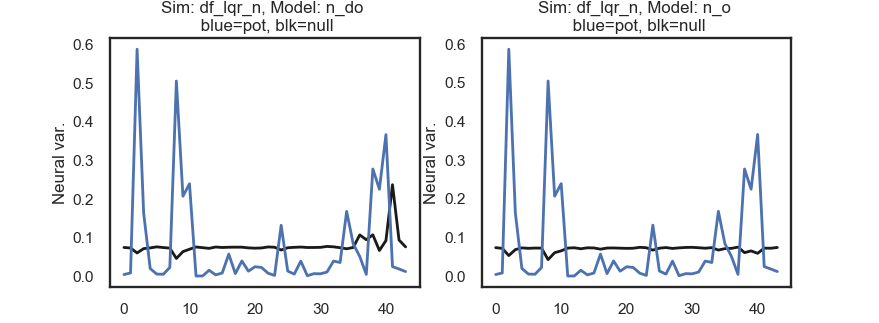

<IPython.core.display.Javascript object>


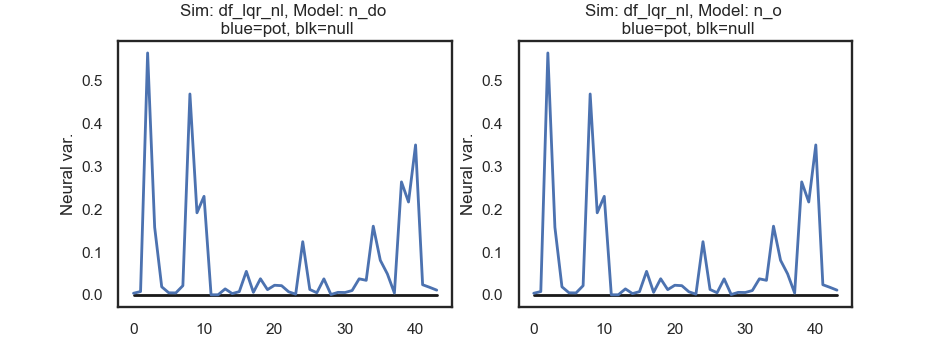

In [16]:
for sim in ['df_lqr_n', 'df_lqr_nl']: 
    f, ax = plt.subplots(ncols = 2)
    
    for i_m, model in enumerate(['n_do', 'n_o']): 

        act, com, cond, pot, null_act, pot_act = \
            return_null_lqr_data(model = model, simulation=sim)
        
        ax[i_m].set_title('Sim: %s, Model: %s \n blue=pot, blk=null'%(sim, model))
        ax[i_m].plot(np.var(null_act, axis=0), 'k-')
        ax[i_m].plot(np.var(pot_act, axis=0), 'b-')
        ax[i_m].set_ylabel('Neural var.')
        if sim == 'df_lqr_nl': 
            assert(np.allclose(np.var(null_act, axis=0), 0.))

<IPython.core.display.Javascript object>


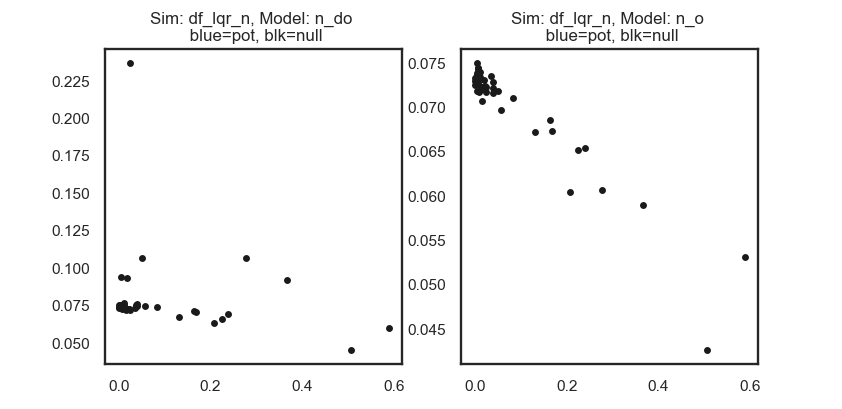

<IPython.core.display.Javascript object>


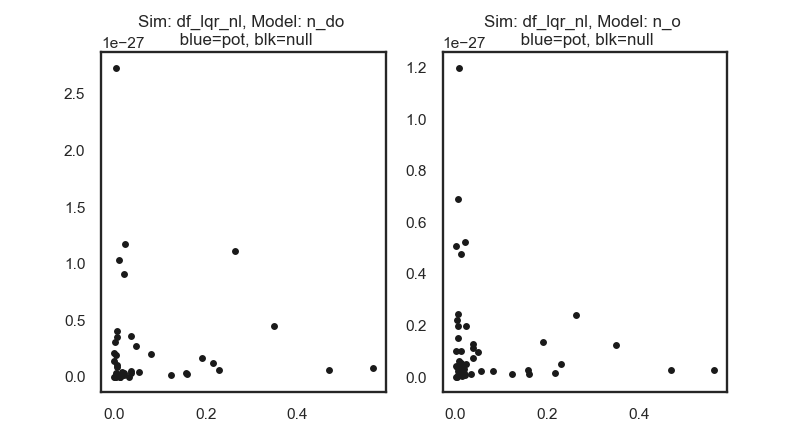

In [18]:
###### correlation b/w null / potent ##########
for sim in ['df_lqr_n', 'df_lqr_nl']: 
    f, ax = plt.subplots(ncols = 2)
    
    for i_m, model in enumerate(['n_do', 'n_o']): 

        act, com, cond, pot, null_act, pot_act = \
            return_null_lqr_data(model = model, simulation=sim)
        
        ax[i_m].set_title('Sim: %s, Model: %s \n blue=pot, blk=null'%(sim, model))
        nv = np.var(null_act, axis=0)
        pv = np.var(pot_act, axis = 0)
        ax[i_m].plot(pv, nv, 'k.')
        #ax[i_m].plot(np.var(null_act, axis=0), 'k-')
        #ax[i_m].plot(np.var(pot_act, axis=0), 'b-')
        #ax[i_m].set_ylabel('Neural var.')
        if sim == 'df_lqr_nl': 
            assert(np.allclose(np.var(null_act, axis=0), 0.))

<IPython.core.display.Javascript object>


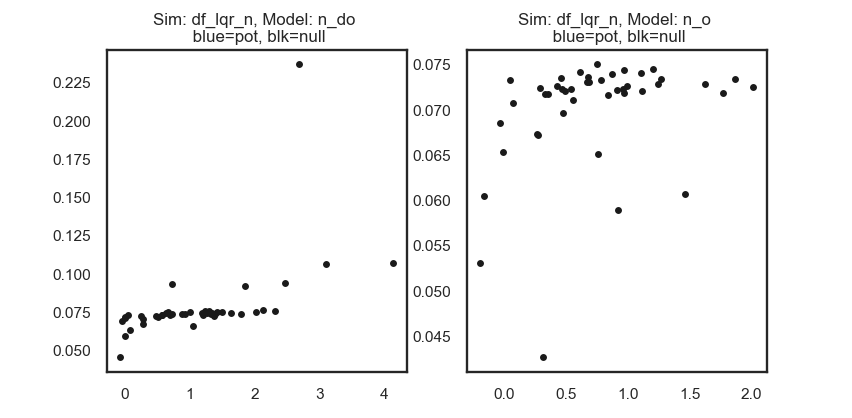

<IPython.core.display.Javascript object>


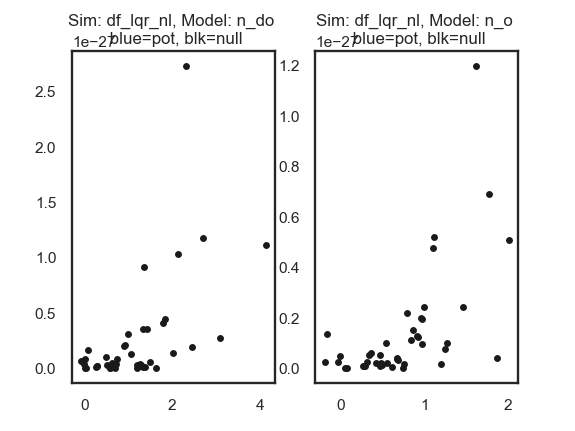

In [31]:
###### mean vs. variance of null activity ##########
for sim in ['df_lqr_n', 'df_lqr_nl']: 
    f, ax = plt.subplots(ncols = 2)
    
    for i_m, model in enumerate(['n_do', 'n_o']): 

        act, com, cond, pot, null_act, pot_act = \
            return_null_lqr_data(model = model, simulation=sim)
        
        ax[i_m].set_title('Sim: %s, Model: %s \n blue=pot, blk=null'%(sim, model))
        nv = np.var(null_act, axis=0)
        nm = np.mean(null_act, axis = 0)
        ax[i_m].plot(nm, nv, 'k.')
        #ax[i_m].plot(np.var(null_act, axis=0), 'k-')
        #ax[i_m].plot(np.var(pot_act, axis=0), 'b-')
        #ax[i_m].set_ylabel('Neural var.')
        if sim == 'df_lqr_nl': 
            assert(np.allclose(np.var(null_act, axis=0), 0.))

In [35]:
###### is null mean/variance diff for diff commands/conditions 
sim ='df_lqr_n'
model = 'n_o'
act, command, condition, pot, null_act, pot_act = \
    return_null_lqr_data(model = model, simulation=sim)

colors = ['maroon', 'orangered', 'goldenrod', 'olivedrab', 'teal', 'steelblue', 'navy', 'magenta']
alphas = [1., .7, .4]
pool_factor = 10; 
nshuffs = 100; 
nneurons = act.shape[1]

### Visualize mean + variance activity for each condition in a bunch of command plots 
zscores = {}; 
for i in range(nneurons): 
    zscores[i] = []; 
    
for com in range(32): 
    #f, ax = plt.subplots()
    #ax.set_title('Com %d'%com)
    cnt = 0; 
    for cond in range(24): 
        
        ### Get this 
        ix = np.nonzero(np.logical_and(condition == cond, command == com))[0]
        
        ### If enough observations 
        if len(ix) > 15: 
            
            ### Get all command activity: 
            ix2 = np.nonzero(command == com)[0]
            
            ### Chekc pool factor 
            if float(len(ix2))/float(len(ix)) > pool_factor: 
                
                ### Get shuffles: 
                shuff = []; 
                for s in range(nshuffs): 
                    six = np.random.permutation(len(ix2))[:len(ix)]
                    shuff.append(np.mean(null_act[ix2[six], :], axis=0))
                shuff = np.vstack((shuff))
                
                shuff_mn = np.mean(shuff,axis=0)
                shuff_st = np.std(shuff, axis=0)
                
                cond_col = int(cond % 8)
                cond_alpha = int(np.floor(cond / 8.))

                ### True mean
                mn = np.mean(null_act[ix, :], axis=0)
                
                ### Plot z-score: 
                z = (mn - shuff_mn ) / shuff_st
#                 ax.plot(np.arange(nneurons) + cnt*.1, z, '*-',  
#                         color=colors[cond_col], alpha=alphas[cond_alpha])
                
                for i in range(nneurons): 
                    zscores[i].append(z[i])
    
                
                cnt += 1
    ax.hlines([1.96, -1.96], 0, 44, 'k')
    ax.set_xlim([-1, nneurons])
    f.tight_layout()
            

<IPython.core.display.Javascript object>


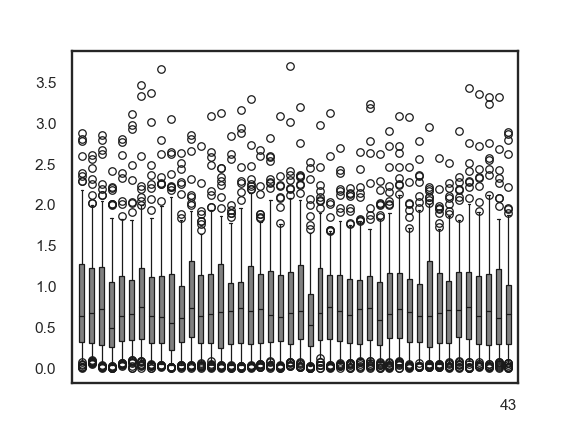

(-1, 44)

In [47]:
f, ax= plt.subplots()
z_mn = []
for i in range(nneurons): 
    util_fcns.draw_plot(i, np.abs(zscores[i]), 'k', 'gray', ax)
    z_mn.append(np.mean(np.abs(zscores[i])))
ax.set_xlim([-1, 44])

<IPython.core.display.Javascript object>


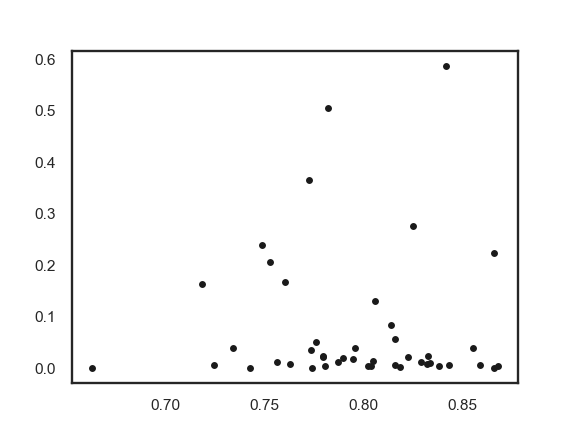

In [49]:
f, ax =plt.subplots()
for sim in ['df_lqr_n']: 
    for i_m, model in enumerate(['n_o']): 

        act, com, cond, pot, null_act, pot_act = \
            return_null_lqr_data(model = model, simulation=sim)
        
        #ax[i_m].set_title('Sim: %s, Model: %s \n blue=pot, blk=null'%(sim, model))
        pv = np.var(pot_act, axis=0)
        #nm = np.mean(null_act, axis = 0)
        ax.plot(z_mn, pv, 'k.')